<a href="https://colab.research.google.com/github/TanushGoel/Gordon-RamsAI/blob/master/Gordon_RamsAI_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -q -o "/content/recipes_webscraped.csv.zip"

In [ ]:
import pandas as pd

data = pd.read_csv("/content/recipes_webscraped.csv")
print(len(data))
data.head()

517129


,name,ingredients,steps
0,buttermilk pie with gingersnap crumb crust,sugar margarine egg egg whites flour salt butt...,"preheat oven to 350°f. make pie crust, using 8..."
1,boston cream pie,margarine cake flour powder salt sugar oil van...,beat egg whites until soft peaks form. gradual...
2,betty crocker's southwestern guacamole dip,avocados medium tomatoes salt cloves garlic li...,peel and mash avocados until lumpy. add remain...
3,calzone,parker house rolls tomato sauce onion basil le...,open rolls and let stand until they reach room...
4,buttermilk ranch dressing,clove garlic salt buttermilk sour cream lime j...,mash together garlic and salt to form a paste....


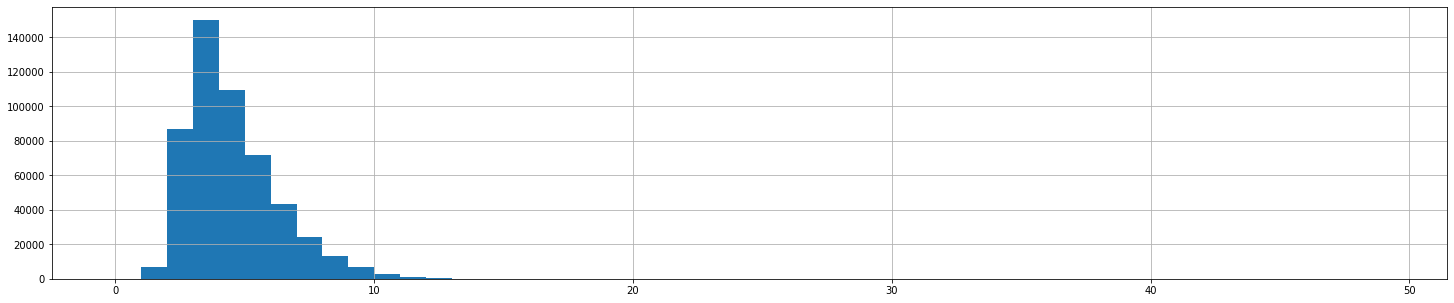

In [ ]:
import numpy as np

pd.DataFrame([len(text.split()) for text in data.name])[0].hist(bins=np.arange(start=0, stop=50, step=1), figsize=[25,5])

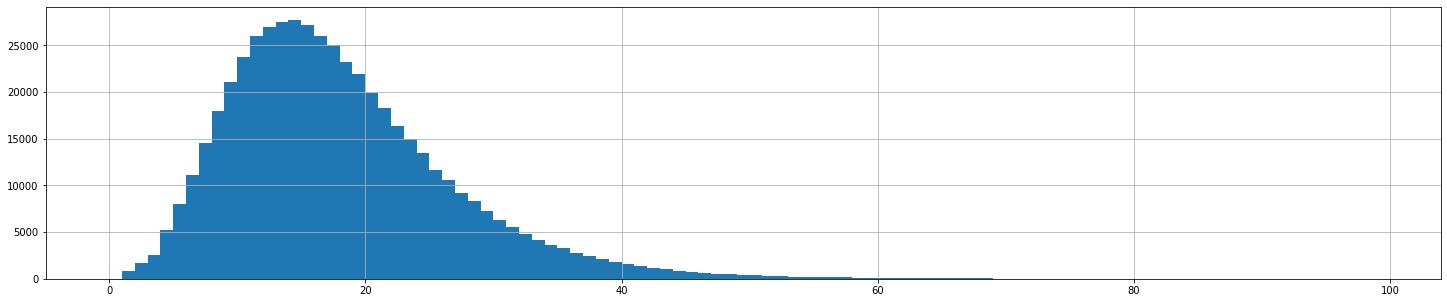

In [ ]:
pd.DataFrame([len(str(text).split()) for text in data.ingredients])[0].hist(bins=np.arange(start=0, stop=100, step=1), figsize=[25,5])

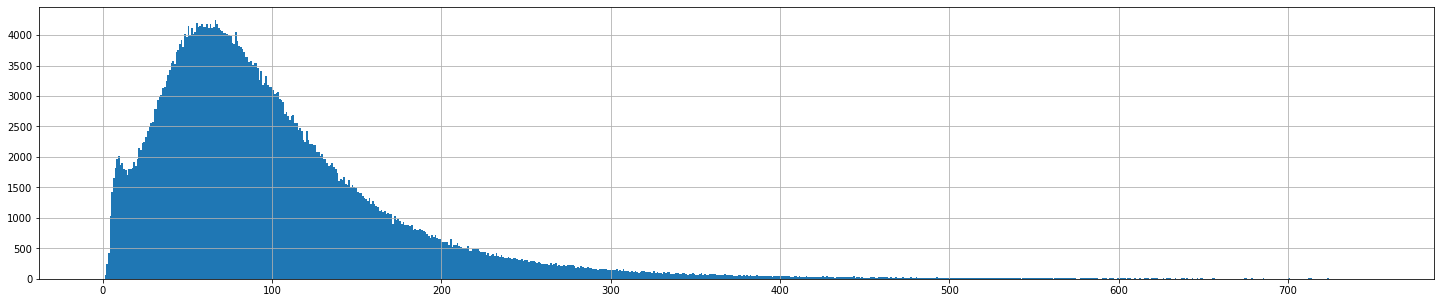

In [ ]:
pd.DataFrame([len(str(text).split()) for text in data.steps])[0].hist(bins=np.arange(start=0, stop=750, step=1), figsize=[25,5])

In [ ]:
max_name_len = 24
max_ingreds_len = 64
max_steps_len = 512

upper_bound_steps = 640
data = data[data['steps'].str.split().str.len().le(upper_bound_steps)]

print(len(data))
data.head()

516531


,name,ingredients,steps
0,buttermilk pie with gingersnap crumb crust,sugar margarine egg egg whites flour salt butt...,"preheat oven to 350°f. make pie crust, using 8..."
1,boston cream pie,margarine cake flour powder salt sugar oil van...,beat egg whites until soft peaks form. gradual...
2,betty crocker's southwestern guacamole dip,avocados medium tomatoes salt cloves garlic li...,peel and mash avocados until lumpy. add remain...
3,calzone,parker house rolls tomato sauce onion basil le...,open rolls and let stand until they reach room...
4,buttermilk ranch dressing,clove garlic salt buttermilk sour cream lime j...,mash together garlic and salt to form a paste....


In [ ]:
!pip3 install -q transformers
import transformers

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
elements = len(tokenizer.get_vocab())
print(elements)

30522


In [ ]:
def tokenize_name(sentence):

    return tokenizer.encode_plus(str(sentence), max_length=max_name_len,
                                 truncation=True, padding='max_length',
                                 add_special_tokens=True, return_token_type_ids=False, return_attention_mask=False)['input_ids']

def tokenize_ingreds(sentence):

    return tokenizer.encode_plus(str(sentence), max_length=max_ingreds_len,
                                 truncation=True, padding='max_length',
                                 add_special_tokens=True, return_token_type_ids=False, return_attention_mask=False)['input_ids']

def tokenize_steps(sentence):

    return tokenizer.encode_plus(str(sentence), max_length=max_steps_len,
                                 truncation=True, padding='max_length',
                                 add_special_tokens=True, return_token_type_ids=False, return_attention_mask=False)['input_ids']

def decode(tokenized):

    return tokenizer.decode(tokenized, skip_special_tokens=True)

In [ ]:
data.steps.iloc[0]

In [ ]:
print(tokenize_steps(data.steps.iloc[0]))

In [ ]:
decode(tokenize_steps(data.steps.iloc[0]))

In [ ]:
def augment(sentence):

    sentence = str(sentence).lower().split()
    np.random.shuffle(sentence)
    sentence = sentence[:np.random.randint(0, len(sentence))]

    return " ".join(sentence)

In [ ]:
data.ingredients.iloc[42]

'package dry yeast water sugar salt oil flour cornmeal jar ragu pizza sauce mozzarella cheese oregano pepper pepperoni olive green pepper mushroom parmesan cheese'

In [ ]:
augment(data.ingredients.iloc[42])

'ragu pepperoni salt mozzarella oil cheese sauce sugar pepper oregano pizza cheese dry cornmeal jar green yeast pepper mushroom olive water flour package'

In [ ]:
def generator(meta_batch_siz, batch_siz, df, aug=False):

    if meta_batch_siz % batch_siz != 0:
        raise ValueError(f"meta-batch size = {meta_batch_siz} should be divisible by batch size = {batch_siz}")

    while True:

        df = df.sample(frac=1).reset_index(drop=True)

        namez, ingredz, steps, labels = [], [], [], []

        for index in range(len(df)):

            start = 1

            if aug:
                n = np.array(tokenize_name(augment(df.name.iloc[index])), dtype="int32")
                i = np.array(tokenize_ingreds(augment(df.ingredients.iloc[index])), dtype="int32")
            else:
                n = np.array(tokenize_name(df.name.iloc[index]), dtype="int32")
                i = np.array(tokenize_ingreds(df.ingredients.iloc[index]), dtype="int32")

            stepz = tokenize_steps(df.steps.iloc[index])

            for idx in range(start, len([i for i in stepz if i != 0])-1):

                steps.append(np.array(stepz[:idx]+[0]*(max_steps_len-idx), dtype="int32"))
                labels.append(np.array(stepz[idx], dtype="int32"))
                namez.append(n)
                ingredz.append(i)

                if len(labels) == meta_batch_siz: 

                    temp = list(zip(namez, ingredz, steps, labels)) 
                    np.random.shuffle(temp) 
                    namez, ingredz, steps, labels = zip(*temp) 
                    del temp

                    for j in range(meta_batch_siz // batch_siz):
                        yield ({model.inputs[0].name: np.array(namez[j*batch_siz:(j+1)*batch_siz]).reshape(batch_siz, max_name_len), 
                                model.inputs[1].name: np.array(ingredz[j*batch_siz:(j+1)*batch_siz]).reshape(batch_siz, max_ingreds_len), 
                                model.inputs[2].name: np.array(steps[j*batch_siz:(j+1)*batch_siz]).reshape(batch_siz, max_steps_len)},
                                np.array(labels[j*batch_siz:(j+1)*batch_siz]).reshape(batch_siz, 1))

                    start = idx + 1
                    namez, ingredz, steps, labels = [], [], [], []

        for j in range(0, len(labels), batch_siz):
              a = np.array(namez[j:j+batch_siz])
              b = np.array(ingredz[j:j+batch_siz])
              c = np.array(steps[j:j+batch_siz])
              d = np.array(labels[j:j+batch_siz])
              yield ({model.inputs[0].name: a.reshape(len(a), max_name_len), 
                      model.inputs[1].name: b.reshape(len(b), max_ingreds_len), 
                      model.inputs[2].name: c.reshape(len(c), max_steps_len)},
                      d.reshape(len(d), 1))

In [ ]:
import tensorflow as tf

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'projection_dim': self.projection_dim,
            'query_dense': self.query_dense,
            'key_dense': self.key_dense,
            'value_dense': self.value_dense,
            'combine_heads': self.combine_heads,
        })
        return config

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'att': self.att,
            'ffn': self.ffn,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2,
        })
        return config

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'token_emb': self.token_emb,
            'pos_emb': self.pos_emb,
        })
        return config

In [ ]:
def attention_block(prev_layer): 

    # prev_layer.shape = (batch_size, time_steps, input_dim)

    time_steps = prev_layer.shape[1]
    input_dim = prev_layer.shape[2]

    x = tf.keras.layers.Permute((2, 1))(prev_layer) # (batch_size, input_dim, time_steps)
    x = tf.keras.layers.Dense(time_steps, activation='softmax')(x) # attention matrix
    x = tf.keras.layers.Permute((2, 1))(x) # (batch_size, time_steps, input_dim)

    self_weighted_attention = tf.keras.layers.Multiply()([prev_layer, x])

    return self_weighted_attention

In [ ]:
tf.keras.backend.clear_session()

embed_dim = 128
num_heads = 8 
ff_dim = 512 

input_name = tf.keras.layers.Input(shape=(max_name_len,), dtype="int32", name='name_input')
name_embed = TokenAndPositionEmbedding(max_name_len, elements, embed_dim)(input_name)
name_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(name_embed)

input_ingreds = tf.keras.layers.Input(shape=(max_ingreds_len,), dtype="int32", name='ingreds_input')
ingreds_embed = TokenAndPositionEmbedding(max_ingreds_len, elements, embed_dim)(input_ingreds)
ingreds_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(ingreds_embed)

concat_name_ingreds = tf.keras.layers.concatenate([name_transformer, ingreds_transformer], axis=1)
name_ingreds_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(concat_name_ingreds)
name_ingreds_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(name_ingreds_transformer)
name_ingreds_pooled_output = tf.keras.layers.GlobalMaxPooling1D()(name_ingreds_transformer)

input_steps = tf.keras.layers.Input(shape=(max_steps_len,), dtype="int32", name='steps_input')
steps_embed = TokenAndPositionEmbedding(max_steps_len, elements, embed_dim)(input_steps)
steps_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(steps_embed)
steps_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(steps_transformer)
steps_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(steps_transformer)
steps_pooled_output = tf.keras.layers.GlobalMaxPooling1D()(steps_transformer)

concat_feats = tf.keras.layers.concatenate([name_ingreds_pooled_output, steps_pooled_output], axis=1)

fc = tf.keras.layers.Dense(256, activation=tf.keras.activations.swish)(concat_feats)
drop = tf.keras.layers.AlphaDropout(0.075)(fc)
fc = tf.keras.layers.Dense(64, activation=tf.keras.activations.swish)(drop)

output = tf.keras.layers.Dense(elements, activation="softmax", name='output')(fc) 

model = tf.keras.models.Model(inputs=[input_name, input_ingreds, input_steps], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name_input (InputLayer)         [(None, 24)]         0                                            
__________________________________________________________________________________________________
ingreds_input (InputLayer)      [(None, 64)]         0                                            
__________________________________________________________________________________________________
token_and_position_embedding (T (None, 24, 128)      3909888     name_input[0][0]                 
__________________________________________________________________________________________________
token_and_position_embedding_1  (None, 64, 128)      3915008     ingreds_input[0][0]              
______________________________________________________________________________________________

In [ ]:
tf.keras.backend.clear_session()

embed_dim = 128
num_heads = 8 
ff_dim = 512 

input_name = tf.keras.layers.Input(shape=(max_name_len,), dtype="int32", name='name_input')
name_embed = TokenAndPositionEmbedding(max_name_len, elements, embed_dim)(input_name)
name_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(name_embed)

input_ingreds = tf.keras.layers.Input(shape=(max_ingreds_len,), dtype="int32", name='ingreds_input')
ingreds_embed = TokenAndPositionEmbedding(max_ingreds_len, elements, embed_dim)(input_ingreds)
ingreds_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(ingreds_embed)

concat_name_ingreds = tf.keras.layers.concatenate([name_transformer, ingreds_transformer], axis=1)
name_ingreds_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(concat_name_ingreds)
name_ingreds_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(name_ingreds_transformer)

input_steps = tf.keras.layers.Input(shape=(max_steps_len,), dtype="int32", name='steps_input')
steps_embed = TokenAndPositionEmbedding(max_steps_len, elements, embed_dim)(input_steps)
steps_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(steps_embed)
steps_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(steps_transformer)

concat_transformers = tf.keras.layers.concatenate([name_ingreds_transformer, steps_transformer], axis=1)
concat_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(concat_transformers)
concat_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(concat_transformer)

pool = tf.keras.layers.GlobalAveragePooling1D()(concat_transformer)

fc = tf.keras.layers.Dense(256, activation=tf.keras.activations.swish)(pool)
drop = tf.keras.layers.AlphaDropout(0.075)(fc)
fc = tf.keras.layers.Dense(64, activation=tf.keras.activations.swish)(drop)

output = tf.keras.layers.Dense(elements, activation="softmax", name='output')(fc) 

model = tf.keras.models.Model(inputs=[input_name, input_ingreds, input_steps], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name_input (InputLayer)         [(None, 24)]         0                                            
__________________________________________________________________________________________________
ingreds_input (InputLayer)      [(None, 64)]         0                                            
__________________________________________________________________________________________________
token_and_position_embedding (T (None, 24, 128)      3909888     name_input[0][0]                 
__________________________________________________________________________________________________
token_and_position_embedding_1  (None, 64, 128)      3915008     ingreds_input[0][0]              
______________________________________________________________________________________________

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
meta_batch_size = 1310720
batch_size = 128
model.fit(generator(meta_batch_size, batch_size, data), 
          epochs=10)

In [ ]:
def make_recipe(name, ingreds):

    name = np.array(tokenize_name(augment(name)), dtype="int32").reshape(1, max_name_len)
    ingreds = np.array(tokenize_ingreds(augment(ingreds)), dtype="int32").reshape(1, max_ingreds_len)

    steps = [101]+[0]*(max_steps_len-1)

    preds = [101]

    for i in range(1, 512): 

        pred = np.argmax(model.predict({model.inputs[0].name: name, 
                         model.inputs[1].name: ingreds, 
                         model.inputs[2].name: np.array(steps, dtype="int32").reshape(1, max_steps_len)}))
        
        if pred == 102:
            break

        preds.append(pred)
        steps[i] = pred
    
    return decode(preds)

In [ ]:
make_recipe("best chocolate chip cookies", "butter sugar eggs vanilla extract baking soda hot water salt flour chocolate chips walnuts")